<a href="https://colab.research.google.com/github/premonish/YOUNGER/blob/main/YOUNGER_Age_Estimator_PREPROCESS_MODEL_050421_2239.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **YOUNGER - Age Estimator**

# **IV. PREPROCESSING**

## **4.1 Contents**
* 4.1 Contents
* [4.2 Introduction](https://https://colab.research.google.com/drive/13W1JpeaFqpM0VrJFvKBFVzK4AiYJldT3#)
* 4.3 Imports
* 4.4 Load Data
* 4.5 Transform Data
* 4.6 Train/Test Split
* 4.7 CNN Architecture
* 4.8 Transfer Learning
* 4.9 Summary
* 4.10 References


---



##**4.2 Introduction**

Previously, to create an age-predictor, we have completed a notebook to import data and explore its attributes: [Data Wrangling & Exploratory Data Analysis](https://github.com/premonish/YOUNGER/blob/main/notebooks/YOUNGER_Age_Estimator_WRANGLING_EDA_v2.ipynb). We took a close look at the metadata and plotted some histograms of the variable distributions. We transformed the data to extract the age of the primary face in each image from their date-of-birth and the date the photo was taken. We focused on extracting a long array of vectors of the pixel information per photo. We finished the previous phase by creating 2 arrays: 'matrix_x' with each row containing the (150,000+ pixel/image) data from each image in the dataset, and 'vector_y' containing the corresponding 'age' labels for the images. 

In this notebook, we will focus on Preprocessing & Modeling. In particular, we will use a Convolutional Neural Network, which is industry standard for Machine Learning image classification tasks due to its unmatched performance.  


---



### **Class Balance Note:** 
We decided to focus on predicting only the well represented age classes [8-80]. The dataset did not contain enough examples of other ages. Since the dataset had many examples for other ages, we decided to downsample to balance the classes.


**Historical Context** 
>
> Image classification has been around for decades, however the field has been rapidly maturing in the last decade.  Since 2010, [ImageNet](https://https://en.wikipedia.org/wiki/ImageNet) Large Scale Visual Recognition Challenge (ILSVRC) is an annual competition where teams attempt to categorize thousands of images into 1,000 classes. In 2012, 'AlexNet' won the competition by a landslide and this is considered a pivotal moment in the history of deep learning, enabled by ingenious data scientists, a massive labeled dataset, and GPUs for training.




**PREPROCESSING** will be focused on three main sections.

1. Create Dummy Variables for categorical variables. (One-Hot Encoding)
2. Standardize the magnitude of numeric features using a scaler. (Scale 0-1)
3. Split data into testing and training datasets.

**MODELING** will focus on the following four phases.
1. Train the models on the dataset (fit)
2. Review model performance metrics
3. Iterate over other models
4. Identify the final model  


---



## **4.3 Imports**

In [1]:
# !pip install tensorflow

In [2]:
# Create a list of currently installed python libraries for posterity
# !pip freeze > requirements.txt

In [3]:
### IMPORT libraries and packages ###
### I get by with a little help from my friends ###
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

# deep-learning imports
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.layers import Dense, Activation, Dropout, Flatten, Input, Convolution2D, ZeroPadding2D, MaxPooling2D, Activation
from keras.layers import Conv2D, AveragePooling2D
from keras.models import Model, Sequential
from keras import metrics
from keras.models import model_from_json

In [4]:
# mount GDrive where the dataset is stored for Colab environment
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **4.4 Load Data**
Let's load the compressed numpy arrays from disk, extract data, and check the number of rows in our dataset.

In [5]:
%%time
from numpy import asarray, savez_compressed, load
# load dict of arrays
images = np.load('/content/drive/MyDrive/YOUNGER/data5.npz', allow_pickle=True)
matrix_x = images.f.arr_0
X = matrix_x
X.shape

CPU times: user 13.4 s, sys: 1.96 s, total: 15.4 s
Wall time: 15.4 s


In [6]:
# load the ages array 'vector_y'
ages = np.load('/content/drive/MyDrive/YOUNGER/data6.npz', allow_pickle=True)
vector_y = ages.f.arr_0
y = vector_y
y.shape

(5037,)

In [7]:
# check output matrix_x & vector_y shapes
# both matrix_x and vector_y are arrays of the same length 
assert vector_y.shape == matrix_x.shape

**NOTE:** I've run many tests to see how many images to include without overwhelming Google Colab's RAM. 

I have already upgraded to Colab Pro for this project and have been reaching the RAM limits

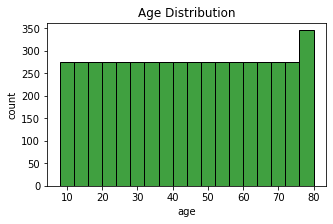

In [8]:
# Plot Age Distribution represented in the dataset
import seaborn as sns
plt.figure(figsize=(5, 3))
sns.histplot(y, color='green')
plt.title('Age Distribution')
plt.xlabel('age')
plt.ylabel('count');

**^ Notice the balanced classes of the input data achieved in preprocessing as noted above.**

## **4.5 Transform Data**

**One-Hot Encoding**

We need to encode the 'ages' label as categorical (binary) representations to prevent a hierarchical interpretation. 
The Keras API provides a 'to_categorical()' method that can be used to one-hot encode integer data. 

In [9]:
# classes = 101   # ages 0 to 100   # We didn't have enough training examples to predict 101 classes
classes = 73      # ages 8 to 80 (inclusive - inclusive)
target = y-8      # prepare for zero-indexed encoding - must add for prediction

# "Converts a class vector (integers) to binary class matrix." 
target_classes = keras.utils.to_categorical(target, classes) 

**Reshaping the Data**

We must reshape the data into the standard input array shape of a 'rank 4 tensor' to prepare for the Tensorflow CNN.

(b, w, h, c) : (batch, width, height, channels)

In [10]:
features = []
for i in range(0, len(X)):
    features.append(X[i])
features = np.array(features)
features = features.reshape(len(X),224,224,3)
features.shape

(5037, 224, 224, 3)

**Scale the Data**

Each of the pixel values range from 0-255. Let's scale the values to from 0-1 by dividing each value by 255. Interestingly, we are actually performing this operation virtually instantly 150,528 times per image (times the number of images).

In [11]:
features /= 255        # scale down pixel values to range [0, 1]
print("The maximum value in our dataset is:", features.max())

The maximum value in our dataset is: 1.0


## **4.6 Train/Test Split**
We will divide the dataset randomly into training data and test data (80/20). We will later perform data augmentation on only the training set to help balance the classes of ages in the dataset.

In [12]:
# train/ test split
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(features, target_classes, test_size=0.20, random_state=42 , stratify=target_classes)

In [13]:
print("X_train shape =" ,train_x.shape) 
print("X_test  shape ="  ,test_x.shape)
print('- - - - - - - - - - - - - - - - - -')
print("y_train shape =" ,train_y.shape)
print("y_test  shape ="  ,test_y.shape)

X_train shape = (4029, 224, 224, 3)
X_test  shape = (1008, 224, 224, 3)
- - - - - - - - - - - - - - - - - -
y_train shape = (4029, 73)
y_test  shape = (1008, 73)


## **4.7 CNN Architecture**

I'll start by testing an established effective architecture (VGG-Face model) for this task along with trained weights. ***[UPDATE REQUIRED: INCLUDE CITATION & DETAILS]***.
https://www.robots.ox.ac.uk/~vgg/publications/2015/Parkhi15/parkhi15.pdf

In [14]:
#VGG-Face model
model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(Convolution2D(4096, (7, 7), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, (1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(2622, (1, 1)))
model.add(Flatten())
model.add(Activation('softmax'))

## **4.8 Transfer Learning**

Transfer learning allows us to use weights that have already been trained on a massive dataset. For similar tasks, we can simply freeze the weights for many of the early layers. However, the later layers in the model will need to trained and tuned for our specific task.

**Trained weights source:** 
https://www.robots.ox.ac.uk/~vgg/publications/2015/Parkhi15/parkhi15.pdf

In [15]:
# load the pre-trained weights to take advantage of transfer learning
model.load_weights('/content/drive/MyDrive/YOUNGER/vgg_face_weights.h5')

In [16]:
# freeze layers to use transfer learning effectively
for layer in model.layers[:-7]:
  layer.trainable = False

# add custom layers to predict on unique dataset and problem 
base_model_output = Sequential()
base_model_output = Convolution2D(73, (1, 1), name='predictions')(model.layers[-4].output)
base_model_output = Flatten()(base_model_output)
base_model_output = Activation('softmax')(base_model_output)
 
age_model = Model(inputs=model.input, outputs=base_model_output)

In [17]:
#check trainable layers
if False:
    for layer in model.layers:
        print(layer, layer.trainable)
    
    print("------------------------")
    for layer in age_model.layers:
        print(layer, layer.trainable)

In [18]:
# Stochastic Gradient Descent = sgd
# compile the model
# sgd = keras.optimizers.SGD(lr=1e-3, decay=1e-6, momentum=.9, nesterov=True)

opt = keras.optimizers.Adam(learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    name="Adam"
)

# 'categorical_crossentropy' is an appropriate loss function for a multi-class classification problem such as ours
age_model.compile(loss='categorical_crossentropy'
                  , optimizer = opt
                  # , optimizer = sgd
                  , metrics=['accuracy']
                 )

In [19]:
# create checkpoint which saves the best model based on loss on the validation data 
# if the validation loss decreases, the model will be saved as a checkpoint
checkpointer = ModelCheckpoint(
    # filepath='/content/classification_age_model.hdf5'
    filepath='/content/drive/MyDrive/YOUNGER/classification_age_model_5.hdf5'
    , monitor = "val_loss"
    , verbose=1
    , save_best_only=True
    , mode = 'min'
    # , mode = 'auto'
)

In [20]:
# enable Early Stopping 
# Early Stopping will notice when the validation loss is not improving and 
#    and it will stop the training to prevent overfitting
from tensorflow.keras.callbacks import EarlyStopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5)

In [21]:
# tensorboard allows us to visualize model details and perfomance metrics
%load_ext tensorboard
import datetime

In [22]:
# instantiate TensorBoard and define callback variable
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [23]:
# record model performance
from keras.callbacks import History 
history = History()

In [24]:
# Clear any logs from previous runs - TensorBoard
! rm -rf ./logs/

In [25]:
# set batch size and # of epochs
# fit the model on training set & validate on the test set
# scores = []

enableFit = True

if enableFit:
    # epochs = 250 # original
    # batch_size = 256 # original
    epochs = 100
    batch_size = 128

    for i in range(epochs):
        print("epoch ",i)
        
        ix_train = np.random.choice(train_x.shape[0], size=batch_size)
        
        score = age_model.fit(
            train_x[ix_train], train_y[ix_train]
            , epochs=1
            , validation_data=(test_x, test_y)
            , callbacks=[tensorboard_callback, checkpointer, callback, history]
        )
        
        # scores.append(score)
    
    #restore the best weights
    from keras.models import load_model
    # age_model = load_model('/content/classification_age_model.hdf5')
    age_model = load_model('/content/drive/MyDrive/YOUNGER/classification_age_model_5.hdf5')
    
    age_model.save_weights('/content/drive/MyDrive/YOUNGER/age_model_weights_5.h5')
        
else:
    #pre-trained weights for age prediction: https://drive.google.com/file/d/1YCox_4kJ-BYeXq27uUbasu--yz28zUMV/view?usp=sharing
    age_model.load_weights("/content/drive/MyDrive/YOUNGER/age_model_weights_5.h5")

epoch  0
4/4 [==============================] - 11s 2s/step - loss: 4.2958 - accuracy: 0.0031 - val_loss: 4.2937 - val_accuracy: 0.0198

Epoch 00001: val_loss improved from inf to 4.29373, saving model to /content/drive/MyDrive/YOUNGER/classification_age_model_5.hdf5
epoch  1
4/4 [==============================] - 3s 916ms/step - loss: 4.3155 - accuracy: 0.0312 - val_loss: 4.3722 - val_accuracy: 0.0139

Epoch 00001: val_loss did not improve from 4.29373
epoch  2
4/4 [==============================] - 3s 906ms/step - loss: 4.3963 - accuracy: 0.0000e+00 - val_loss: 4.3181 - val_accuracy: 0.0179

Epoch 00001: val_loss did not improve from 4.29373
epoch  3
4/4 [==============================] - 3s 908ms/step - loss: 4.3408 - accuracy: 0.0234 - val_loss: 4.3153 - val_accuracy: 0.0268

Epoch 00001: val_loss did not improve from 4.29373
epoch  4
4/4 [==============================] - 3s 905ms/step - loss: 4.2959 - accuracy: 0.0156 - val_loss: 4.3118 - val_accuracy: 0.0179

Epoch 00001: val_lo

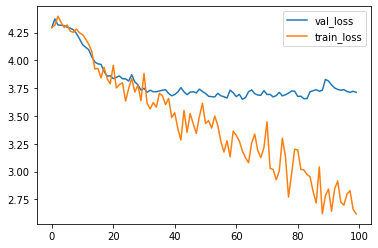

In [26]:
# plot training loss vs. validation loss over epochs
val_loss_change = []; loss_change = []
for i in range(0, epochs):
    val_loss_change.append(history.history['val_loss'][i])
    loss_change.append(history.history['loss'][i])

plt.plot(val_loss_change, label='val_loss')
plt.plot(loss_change, label='train_loss')
plt.legend(loc='upper right')
plt.show()

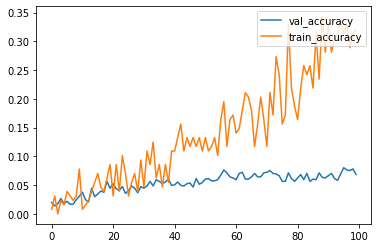

In [27]:
# plot training loss vs. validation loss over epochs
val_accuracy_change = []; accuracy_change = []
for i in range(0, epochs):
    val_accuracy_change.append(history.history['val_accuracy'][i])
    accuracy_change.append(history.history['accuracy'][i])

plt.plot(val_accuracy_change, label='val_accuracy')
plt.plot(accuracy_change, label='train_accuracy')
plt.legend(loc='upper right')
plt.show()

In [ ]:
# !kill 380
%tensorboard --logdir logs/fit

In [29]:
# loss and accuracy on validation set
eval = age_model.evaluate(test_x, test_y, verbose=1 , return_dict=True)
eval

32/32 [==============================] - 2s 62ms/step - loss: 3.6499 - accuracy: 0.0724


{'accuracy': 0.072420634329319, 'loss': 3.649898052215576}

In [30]:
# loss and accuracy on training set
eval2 = age_model.evaluate(train_x, train_y, verbose=1 , return_dict=True)
eval2

126/126 [==============================] - 10s 82ms/step - loss: 3.0179 - accuracy: 0.2492


{'accuracy': 0.24919335544109344, 'loss': 3.0178940296173096}

In [ ]:
predictions = age_model.predict(test_x)

In [ ]:
output_indexes = np.array([i for i in range(8, 81)])
apparent_predictions = np.sum(predictions * output_indexes, axis = 1) + 8

In [69]:
(predictions[0] * output_indexes[0])
print(len(predictions[0]))

1008


In [108]:
min(apparent_predictions)

8.977694611355474

In [102]:
prediction_list = []
for i in range(73):
  prediction_list.append((np.argmax(predictions * output_indexes[i])+8))

print(max(prediction_list))
print(min(prediction_list))

78
8


In [109]:
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix

from sklearn.metrics import confusion_matrix
cm=confusion_matrix(test_y,apparent_predictions)
print(cm)

ValueError: ignored

In [135]:
apparent_predictions[0]
# test_y
test_y_age = np.argmax(test_y, axis=1)
test_y_age  = test_y_age + 8

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


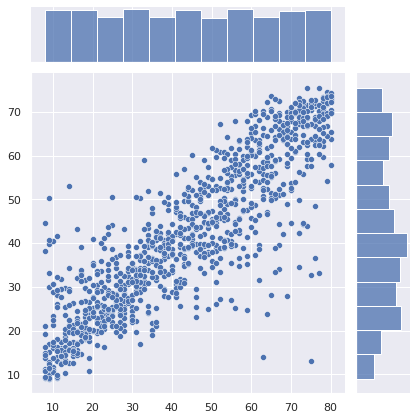

In [166]:
sns.set_theme(style="darkgrid")
# fig, ax = plt.subplots(figsize=(10,10))
sns.jointplot(test_y_age, apparent_predictions)
# ax.scatter(test_y_age, apparent_predictions)
# ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Actual Age')
ax.set_ylabel('Predicted Age');

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


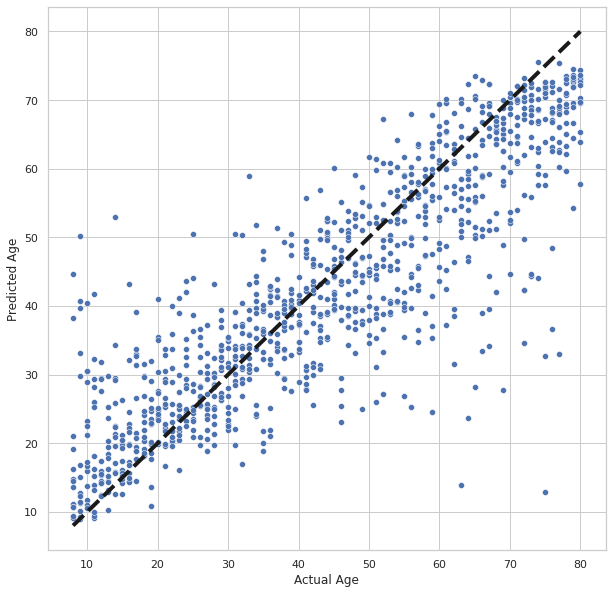

In [167]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(test_y_age, apparent_predictions)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Actual Age')
ax.set_ylabel('Predicted Age');

In [143]:
# corr(test_y_age, apparent_predictions)
np.corrcoef(test_y_age, apparent_predictions)

array([[1.        , 0.86835069],
       [0.86835069, 1.        ]])

In [ ]:
# from sklearn.datasets import make_classification
# from sklearn.metrics import plot_confusion_matrix

# from sklearn.metrics import confusion_matrix
# cm=confusion_matrix(test_y_age,apparent_prediction)
# print(cm)

In [96]:
mae = 0
n = apparent_predictions.shape[0]
for i in range(0, n):
    prediction = int(apparent_predictions[i])
    actual = np.argmax(test_y[i])
    abs_error = abs(prediction - actual)
    mae += abs_error
    
mae = mae / n
print("mae: ",mae)
print("instances: ", n)

mae:  9.403769841269842
instances:  1008


In [52]:
def loadImage(filepath):
    test_img = image.load_img(filepath, target_size=(224, 224))
    test_img = image.img_to_array(test_img)
    test_img = np.expand_dims(test_img, axis = 0)
    test_img /= 255
    return test_img

In [37]:
from keras.preprocessing import image
def image_age(photo):
  prediction = age_model.predict(loadImage(photo))
  img = image.load_img(photo)#, target_size=(224, 224))
  plt.imshow(img)
  plt.show()

  # print("Predicted Age: ", (np.argmax(prediction))+8)
  apparent_age = np.round(np.sum(prediction * output_indexes, axis = 1))
  print("Apparent Age: ", int(apparent_age[0]))
  # print("Predicted Age:",((np.argmax(prediction))+ (int(apparent_age[0])))/2)

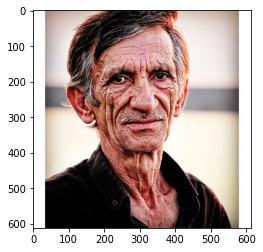

Apparent Age:  65


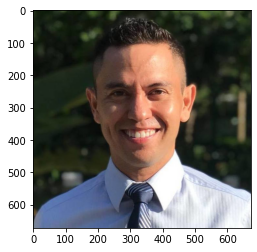

Apparent Age:  32


In [38]:
picture1 = "/content/drive/MyDrive/YOUNGER/face_old.jpeg"
picture2 = "/content/drive/MyDrive/YOUNGER/Baby-Face-Cute.jpg"
picture3 = "/content/drive/MyDrive/YOUNGER/prem_linked.jpg"
# picture4 = ''
image_age(picture1)
# image_age(picture2)
image_age(picture3)
# image_age(picture4)

In [39]:
# prediction1 = image_age(picture3)

# y_pos = np.arange(81)
# plt.bar(y_pos, prediction1[0], align='center', alpha=0.9)
# plt.ylabel('percentage')
# plt.title('age')
# plt.show()

In [40]:
# create a web image upload & predict sequence
from PIL import Image
import requests

def web_age(url):  
  web_photo = Image.open(requests.get(url, stream=True).raw).save("web_photo.jpg")
  image_age("/content/web_photo.jpg")

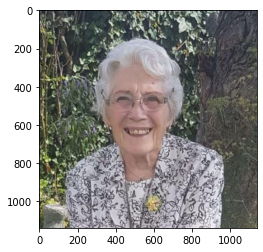

Apparent Age:  58


In [41]:
url = 'https://i.guim.co.uk/img/media/68b70e0ccc658b9b01cc7bf6a972134f2a5136e4/0_186_1900_1139/master/1900.jpg?width=1200&height=1200&quality=85&auto=format&fit=crop&s=c391df10a394dc50fafe584915c753e5'
web_age(url)

In [ ]:
url = 'https://myimagejourney.com/wp-content/uploads/2013/08/2013-04-20-16.02.40.jpg'
web_age(url)

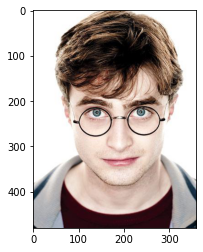

Apparent Age:  26


In [43]:
url = 'https://static.wikia.nocookie.net/harrypotter/images/9/97/Harry_Potter.jpg/revision/latest?cb=20140603201724'
web_age(url)

In [ ]:
url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRed4B_N95FjRE0a-2sn3OEXAjc0SkMkWeJTQ&usqp=CAU'
web_age(url)

In [45]:
age_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_input (InputL [(None, 224, 224, 3)]     0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 114, 114, 64)      0     



---


# **SUMMARY**


---
##**To be updated...**


# **REFERENCES**


1.   https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/ 
2.   https://data.vision.ee.ethz.ch/cvl/publications/papers/proceedings/eth_biwi_01229.pdf
3. https://sefiks.com/2019/02/13/apparent-age-and-gender-prediction-in-keras/ 
4. https://www.researchgate.net/publication/265125544_Face_Detection_without_Bells_and_Whistles
5. https://github.com/yu4u/age-gender-estimation
6. https://www.robots.ox.ac.uk/~vgg/publications/2015/Parkhi15/parkhi15.pdf


---

In [46]:
!tensorboard dev upload \
  --logdir logs/fit \
  --name "My latest experiment" \
  --description "Simple comparison of hyperparameters" \
  --one_shot

2021-05-05 04:42:22.928261: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
Data for the "text" plugin is now uploaded to TensorBoard.dev! Note that uploaded data is public. If you do not want to upload data for this plugin, use the "--plugins" command line argument.

New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/F56pllO6SoCJs40qvmposg/

[2021-05-05T04:42:26] Started scanning logdir.
E0505 04:42:28.503503 140539289978752 uploader.py:1114] Attempted to re-upload existing blob.  Skipping.
E0505 04:42:29.533047 140539289978752 uploader.py:1114] Attempted to re-upload existing blob.  Skipping.
E0505 04:42:30.695389 140539289978752 uploader.py:1114] Attempted to re-upload existing blob.  Skipping.
E0505 04:42:31.491550 140539289978752 uploader.py:1114] Attempted to re-upload existing blob.  Skipping.
E0505 04:42:32.642317 140539289978752 uploader.py:1114] Attempted to re-upload exist